In [6]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.features import shapes
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import slic
from shapely.geometry import shape
from rasterstats import zonal_stats

%matplotlib inline

%load_ext autoreload
%autoreload 2

from gridflow import model
from gridflow.visuals import country_viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Demo notebook
This notebook demonstrates the capabilities of the gridflow package. 

In [7]:
lux = model.region("luxembourg", data_path="data/LUX")

In [8]:
lux.create_subregions(n=5)
lux.create_network()

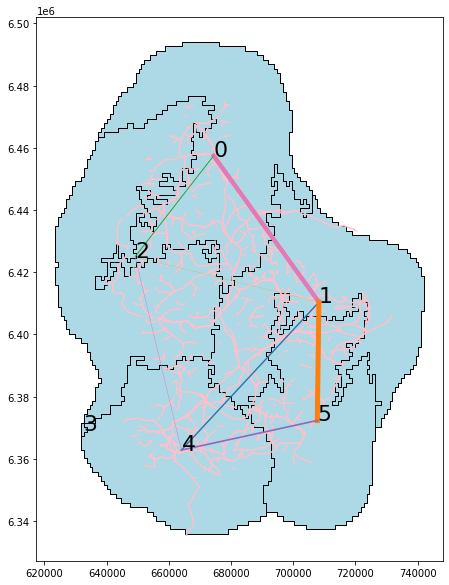

In [6]:
country_viz(lux)

In [9]:
from gridflow.epm_input_generator import generate_epm_inputs

In [47]:
generate_epm_inputs(lux, "data/epm_inputs_raw", "data/epm_inputs_processed", verbose=True)

Processing pDemandProfile
original shape: (365, 27), final shape: (1825, 27), 5 zones.
Processing pDemandForecast
original shape: (2, 29), final shape: (10, 29), 5 zones.
Processing pGenDataExcelDefault
original shape: (11, 15), final shape: (55, 15), 5 zones.
Processing pFuelPrice


ValueError: The input data is not zonal.

In [18]:
lux.subregions["population"]

0     38098.984375
1    163973.468750
2     54629.488281
3    123578.546875
4    652314.875000
Name: population, dtype: float64

In [21]:
pop = lux.subregions["population"]
pop.loc[0]

38098.984375

In [19]:
df = pd.read_csv("data/epm_inputs_raw/load/pDemandForecast.csv")

In [20]:
df.head()

,zone,type,2024,2025,2026,2027,2028,2029,2030,2031,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Gambia,Peak,106,112.980614,120.420935,128.351237,136.803788,145.812980,155.415472,165.650334,...,313.453380,334.095804,356.097632,379.548387,404.543488,431.184637,459.580235,489.845821,522.104542,556.487657
1,Gambia,Energy,696,748.437887,804.826538,865.463612,930.669191,1000.787475,1076.188597,1157.270574,...,2392.765588,2573.040834,2766.898341,2975.361419,3199.530479,3440.588838,3699.808965,3978.559202,4278.310980,4600.646595


In [23]:
scaling = lux.subregions["population"] / np.sum(lux.subregions["population"])

In [24]:
scaling

0    0.036896
1    0.158797
2    0.052905
3    0.119678
4    0.631724
Name: population, dtype: float64

In [25]:
df*3

,zone,type,2024,2025,2026,2027,2028,2029,2030,2031,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,GambiaGambiaGambia,PeakPeakPeak,318,338.941841,361.262804,385.053710,410.411363,437.438941,466.246415,496.951001,...,940.360141,1002.287413,1068.292897,1138.645161,1213.630463,1293.553911,1378.740705,1469.537463,1566.313626,1669.462970
1,GambiaGambiaGambia,EnergyEnergyEnergy,2088,2245.313661,2414.479615,2596.390835,2792.007573,3002.362425,3228.565791,3471.811722,...,7178.296764,7719.122502,8300.695023,8926.084257,9598.591437,10321.766514,11099.426895,11935.677606,12834.932940,13801.939785


In [30]:
orig_df = df

In [32]:
df.columns.difference(exclude_cols)

Index(['2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032',
       '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041',
       '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050'],
      dtype='object')

In [33]:
scaling.loc[sr]

0.03689633493407708

In [36]:
exclude_cols = ["zone", "type"]
new_df = []
for sr in lux.subregions.index:
    df = orig_df.assign(zone=sr)
    df[df.columns.difference(exclude_cols)] *= scaling.loc[sr]
    new_df.append(df)
new_df = pd.concat(new_df, ignore_index=True)

In [37]:
new_df

,zone,type,2024,2025,2026,2027,2028,2029,2030,2031,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,0,Peak,3.911012,4.168571,4.443091,4.735690,5.047558,5.379965,5.734261,6.111890,...,11.565281,12.326911,13.138698,14.003944,14.926172,15.909133,16.956826,18.073515,19.263744,20.532355
1,0,Energy,25.679849,27.614615,29.695150,31.932435,34.338282,36.925390,39.707415,42.699043,...,88.284281,94.935776,102.088408,109.779931,118.050948,126.945118,136.509391,146.794253,157.853995,169.746998
2,1,Peak,16.832525,17.941029,19.122532,20.381844,21.724087,23.154724,24.679574,26.304844,...,49.775585,53.053548,56.547382,60.271301,64.240458,68.471003,72.980151,77.786247,82.908849,88.368798
3,1,Energy,110.522997,118.849998,127.804369,137.433380,147.787857,158.922458,170.895961,183.771569,...,379.964977,408.592219,439.376289,472.479686,508.077152,546.356595,587.520079,631.784895,679.384701,730.570761
4,2,Peak,5.607933,5.977243,6.370873,6.790426,7.237608,7.714240,8.222260,8.763736,...,16.583260,17.675348,18.839356,20.080019,21.402385,22.811836,24.314106,25.915308,27.621956,29.440996
5,2,Energy,36.821901,39.596129,42.579372,45.787378,49.237081,52.946691,56.935790,61.225434,...,126.589334,136.126802,146.382839,157.411584,169.271255,182.024454,195.738503,210.485792,226.344169,243.397344
6,3,Peak,12.685827,13.521250,14.411690,15.360769,16.372351,17.450549,18.599752,19.824636,...,37.513352,39.983788,42.616914,45.423444,48.414798,51.603148,55.001465,58.623578,62.484225,66.599114
7,3,Energy,83.295618,89.571259,96.319718,103.576618,111.380266,119.771855,128.795681,138.499378,...,286.360471,307.935382,331.135785,356.084148,382.912166,411.761455,442.784300,476.144463,512.018040,550.594397
8,4,Peak,66.962703,71.372522,76.072748,81.082507,86.422183,92.113503,98.179624,104.645228,...,198.015902,211.056209,224.955283,239.769679,255.559674,272.389517,290.327687,309.447172,329.825768,351.546394
9,4,Energy,439.679636,472.805887,508.427930,546.733801,587.925705,632.221081,679.853750,731.075150,...,1511.566525,1625.450655,1747.915020,1879.606069,2021.218958,2173.501216,2337.256692,2513.349799,2702.710075,2906.337095


In [ ]:
new_df = pd.concat([
    df.assign(zone=subr) for subr in lux.subregions
], ignore_index=True)